# overview of llc parcel simulation

In [3]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

from dask.delayed import delayed
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

import threading

import warnings
warnings.filterwarnings('ignore')

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.3543625.datarmor0/parcels-55081/libparcels_random_2208d12c-b868-4d6c-a512-c5d8d6bb9165.so


In [1]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=10)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

In [4]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time', 'trajectory'])
df = p['time']

t_start = df.index.min().compute()
t_end = df.index.max().compute()

df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# find id's of initial drifter position
id_t0 = list(df[str(t_start), 'trajectory'].compute())

---

## go for it


In [6]:
def plot_llc_parcels(t_start, 
                     t_end,
                     t_delta='1H',
                     parquet_dir=None,
                     trail=None,
                     flag_drifters=0,
                     ms_drifters=1.,
                     background=None,
                     fig_suffix=None, 
                     fig_dir=None,
                     overwrite=True,
                     offline=True,
                     **kwargs
                    ):
    """ generates plots with drifter tracks and background llc data
    Parameters
    ----------
    t_start: str, pd.Timestamp
        Figures start time
    t_start: str, pd.Timestamp
        Figures end time
    t_delta: str, optional
        Time interval between figures, default is '1H'
    trail: pd.Timedelta, str, optional
        Length of drifter tracks trail
    flag_drifters: int, optional
        Flag drifters that depending on deployment date
        Show all drifters by default
    ms_drifters: float, optional
        Drifter marker size, default to 1.
    background: dict, optional
        Dict containing all background related options
        Passed to plot_pretty
    fig_dir: str, optional
        Path where figures will be stored
    fig_suffix: str, optional
        Added to figure name
    overwrite: boolean, optional
        Controls whether files are overwritten or not, default is True
    offline: boolean, optional
        if True figures production is distributed
        if False figures are produced locally (debug)
    """
    if offline:
        import dask
        dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
    
    if trail is None:
        trail = pd.Timedelta(0)
    elif isinstance(trail, str):
        trail = pd.Timedelta(trail)
        
    bg_kwargs = {'v': 'SST',
                 'dij': 8,
                 'vmin': -2.5,
                 'vmax': 32.5,
                 'gridlines': False,
                 'figsize': (15,6),
                 'region': 'global',
                }
    if isinstance(background, dict):
        bg_kwargs.update(**background)
    bg_v = bg_kwargs['v']
    if 'zarr' in bg_kwargs:
        bg_zarr = bg_kwargs['zarr']
    else:
        bg_zarr = None
    
    if fig_dir is None:
        fig_dir = os.environ['SCRATCH']+'/figs/'
    if fig_suffix is None:
        fig_suffix = ''
    
    t_range = pd.date_range(t_start, t_end, freq=t_delta)

    # llc
    if background:
        if bg_zarr is None:
            if bg_v in ['SSU', 'SSV']:
                llc = load_llc(['SSU', 'SSV'], bg_kwargs['dij'], t_start, t_end)
            else:
                llc = load_llc(bg_v, bg_kwargs['dij'], t_start, t_end)
        else:
            llc = xr.open_zarr(bg_zarr)

    if bg_v in ['SSU', 'SSV']:
        u, v = ut.rotate(llc.SSU, llc.SSV, llc)
    if bg_v is 'SSU':
        llc = u.rename('SSU').to_dataset()
    elif bg_v is 'SSV':
        llc = v.rename('SSV').to_dataset()
    
    # drifters
    if parquet_dir is None:
        parquet_dir = p.parquets['time']
        #parquet_dir = '/home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/time'
    df = dd.read_parquet(parquet_dir)
    df = df.loc[(df.index>=t_start-trail)&(df.index<=t_end)].compute()

    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
    
        for t in t_range:
            
            date = t.strftime('%Y-%m-%d_%HH')
            figname = fig_dir+fig_suffix+date+'.png'
            
            if overwrite or not os.path.isfile(figname) or not offline:

                if background:
                    bg_kwargs['v'] = llc[bg_v].sel(time=t) #.compute()
                    d = pl.plot_pretty(**bg_kwargs)
                    fig, ax = d['fig'], d['ax']
                    if not offline:
                        print('background printed')
                else:
                    fig = plt.figure(figsize=(15,6))
                    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
                
                if trail:
                    # show trailing positions
                    _df = df.loc[(df.index>t-trail)&(df.index<=t)]
                    (_df
                     .groupby('trajectory')
                     .apply(plot_trajectory,
                            ax=ax,
                            transform=ccrs.PlateCarree(),
                            flag_drifters=flag_drifters,
                            ms=ms_drifters,
                           )
                    )
                else:
                    # do not show trailing positions
                    # much much faster
                    _df = df.loc[str(t)]
                    ax.plot(_df.lon, _df.lat,
                            '.', 
                            color='k',
                            transform=ccrs.PlateCarree(),
                            ms=ms_drifters,
                           )

                ax.set_title(date)

                if offline:
                    fig.savefig(figname, dpi=150, bbox_inches = 'tight')
                    plt.close(fig)
                
def load_llc(v, dij, t_start, t_end):
    """ load llc data and subsample
    """
    if isinstance(v, list):
        return xr.merge([load_llc(_v, dij, t_start, t_end) for _v in v])
    ds = (ut
          .load_data(V=[v])
          .sel(time=slice(str(t_start), str(t_end)))
         )
    
    i, j = ut.get_ij_dims(ds[v])
    ds = ds.rename({i: 'i', j: 'j'})
    ds = ds.isel(i=slice(0, None, dij),
                 j=slice(0, None, dij),
                )
    coords = ['XC', 'YC']
    if v in ['SSU', 'SSV']:
        coords = coords + ['CS', 'SN']
    grd = (ut
           .load_grd()[coords]
           .isel(i=slice(0, None, dij), 
                 j=slice(0, None, dij), 
                )
          )
    #       .load_grd()[['XC', 'YC', 'XG', 'YG']]
    llc = xr.merge([ds, grd])
    return llc
    
                
def plot_trajectory(df, 
                    ax=None, 
                    flag_drifters=0,
                    ms=1.,
                    **kwargs,
                   ):
    """ plot single drifter trajectory
    """
    df = df.sort_index()
    dr_id = int(df['trajectory'].unique()[0])
    if flag_drifters==1:
        # skips drifter not initially deployed
        if dr_id in id_t0:
            color='k'
        else:
            return
    elif flag_drifters==2:
        # disinguish with colors both types of drifters
        if dr_id in id_t0:
            color='k'
        else:
            color='0.8'
    else:
        color='k'
    if ax is not None:
        ax.plot(df.lon, df.lat, color=color, **kwargs)
    else:
        plt.plot(df.lon, df.lat, color=color, **kwargs)

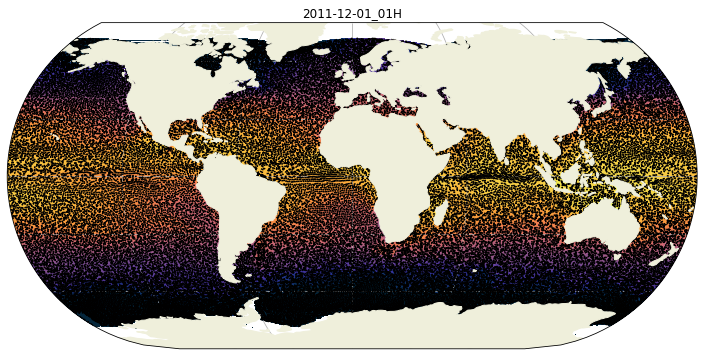

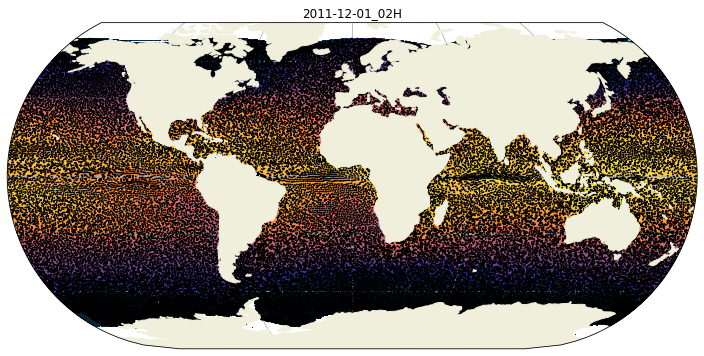

In [12]:
# to create isolated figures:
if True:
    t_start=pd.Timestamp('2011-12-1 00:00:00')
    t_end= t_start + pd.Timedelta('2H')
    plot_llc_parcels(t_start, t_end, 
                     offline=False, 
                     flag_drifters=0,
                    )

In [9]:
t_mv_start = pd.Timestamp('2011-11-16 00:00:00')
t_mv_end = t_end
#t_mv_end = pd.Timestamp('2012-1-1 00:00:00') # debug

#t_mv_range = pd.date_range(t_mv_start, t_mv_end, freq='1D')
t_mv_range = pd.date_range(t_mv_start, t_mv_end, freq='5D')

kwargs = dict(freq='1D',
              region='global_pacific',
              flag_drifters=1,
              background=True,
             )

Nb = len(client.nthreads())
rg = range(0, t_mv_range.size-1)
II = np.array_split(rg,len(rg)/Nb)
print('%d batches to be done'%len(II))

1 batches to be done


In [10]:
#
delayed_fig = delayed(plot_llc_parcels)
#
for I in II:
    print(' batch %d-%d'%(I[0],I[-1]))
    values = [delayed_fig(t_mv_range[i], t_mv_range[i+1], **kwargs) for i in I]
    futures = client.compute(values)
    results = client.gather(futures)

 batch 0-70


In [11]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


---

## regional zooms

Need to prefilter drifter data and store only drifters that pass through the region

and provide the path to `plot_llc_parcels`


**South Atlantic**

In [6]:
region = {"faces": [1, 11, 0, 12], 
          "extent": [-50, 20, -60, 5],
          "dticks": [10, 10],
          "projection": ccrs.LambertAzimuthalEqualArea(central_longitude=-15.0, 
                                                       central_latitude=-30,
                                                      ),
         }

In [16]:
# to create isolated figures:
t_start=pd.Timestamp('2011-12-1 00:00:00')
t_end= t_start + pd.Timedelta('2H')
plot_llc_parcels(t_start, t_end,
                 flag_drifters=0,
                 background={'region': region, 'dij': 4},
                 offline=False,
                )

**Marquises**

In [7]:
def filter_drifters_regionally(df, lon, lat, t_range=None, parquet_dir=None, overwrite=True):
    """ Filter data within a box of longitudes and latitudes and store data
    """
    
    # get id of drifter that goes through the region
    df = df[ (df.lon>lon[0])&(df.lon<lon[1])&(df.lat>lat[0])&(df.lat<lat[1]) ]    
    dr_id = list(df['trajectory'].drop_duplicates().compute())
    df = df[ df.trajectory.isin(dr_id) ]
    
    # could also filter on time
    if t_range is not None:
        df = df.loc[ (df.index>=t_range[0]-pd.Timedelta('5D')) & (df.index<=t_range[1])]
    
    # store
    if parquet_dir is None:
        parquet_dir = ut.scratch
    parquet_path = pa.store_parquet(parquet_dir, df, name='zoom_drifters', overwrite=overwrite)
    
    return parquet_path

def filter_llc_regionally(v, faces, dij, t_range, zarr=None, overwrite=True):
    
    if v in ['SSU', 'SSV']:
        V = ['SSU', 'SSV']
    else:
        V = v
    llc = load_llc(V, dij, t_range[0], t_range[1])
    llc = llc.sel(face=faces)
    
    llc = llc.chunk({'time': 1, 'i': -1, 'j': -1})
    if 'chunks' in llc.niter.encoding:
        del llc.niter.encoding['chunks']
    
    if zarr is None:
        zarr = os.path.join(ut.scratch, 'zoom_llc')
    #
    if overwrite:
        mode='w'
    else:
        mode='w-'
    llc.to_zarr(zarr, mode=mode)
    return zarr

In [8]:
zoom = 0

if zoom==0:
    
    lon = [-140, -130]
    lat = [-20, -10]

    #v, vmin, vmax = 'Eta', -1., 2.
    #v, vmin, vmax = 'SSU', -1., 1.
    #v, vmin, vmax = 'SST', 23., 28.
    #v, vmin, vmax = 'SST', 25., 27.
    v, vmin, vmax = 'SSS', 35., 37

    # param dict for plotting
    region = {'faces': [5, 7, 8, 11],
              'extent':lon+lat,
              'projection': ccrs.PlateCarree(),
              'dticks':[5,5],
             }

    background = {'region': region, 
                  'dij': 2,
                  'v': v,
                  'vmin': vmin,
                  'vmax': vmax,
                  'land': False,
                  'colorbar': True,
                 }

elif zoom==1:
    
    lon = [-136, -134]
    lat = [-16, -14]

    #v, vmin, vmax = 'Eta', -1., 2.
    #v, vmin, vmax = 'SSU', -1., 1.
    #v, vmin, vmax = 'SST', 23., 28.
    v, vmin, vmax = 'SST', 25.5, 26.5

    proj = ccrs.Orthographic(central_longitude=(lon[0]+lon[1])*.5, 
                         central_latitude=(lat[0]+lat[1])*.5, 
                         globe=None,
                        )
    #proj = ccrs.PlateCarree()
    
    # param dict for plotting
    region = {'faces': [8],
              'extent':lon+lat,
              'projection': proj,
              'dticks':[1,1],
             }
    
    background = {'region': region, 
                  'dij': 1,
                  'v': v,
                  'vmin': vmin,
                  'vmax': vmax,
                  'land': False,
                  'colorbar': True,
                 }

In [9]:
t_mv_start = pd.Timestamp('2012-1-1 00:00:00')
#t_mv_end = pd.Timestamp('2012-4-1 00:00:00')
t_mv_end = pd.Timestamp('2012-2-1 00:00:00')

#t_mv_range = pd.date_range(t_mv_start, t_mv_end, freq='1D')
t_mv_range = pd.date_range(t_mv_start, t_mv_end, freq='12H')

In [10]:
parquet_path = filter_drifters_regionally(df, 
                                          lon, lat, 
                                          t_range=tuple(t_mv_range[[0,-1]]),
                                         )

No reindexing
deleting existing archive: /home1/scratch/aponte/zoom_drifters
create new archive: /home1/scratch/aponte/zoom_drifters


In [11]:
background['zarr'] = filter_llc_regionally(v, 
                                           region['faces'], 
                                           background['dij'], 
                                           tuple(t_mv_range[[0,-1]]),
                                          )

In [12]:
parquet_path = "/home1/scratch/aponte/zoom_drifters"
background['zarr'] = "/home1/scratch/aponte/zoom_llc"

background printed
background printed


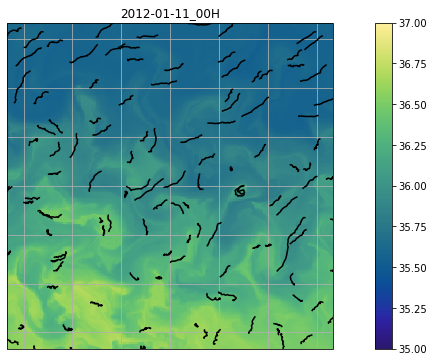

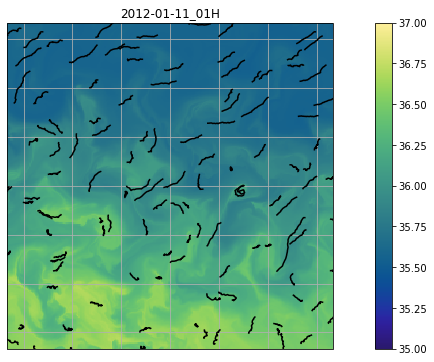

In [23]:
# to create isolated figures:
t_start = t_mv_start + pd.Timedelta('10D')
t_end = t_start + pd.Timedelta('1H')

plot_llc_parcels(t_start, t_end,
                 parquet_dir=parquet_path,
                 flag_drifters=0,
                 trail='5D',
                 ms_drifters=2.,
                 background=background,
                 offline=False,
                )

**go for it**

In [12]:
kwargs = dict(freq='1H',
              parquet_dir=parquet_path,              
              flag_drifters=0,
              trail='5D',
              region=region,
              background=background,
              overwrite=True,
             )

Nb = len(client.nthreads())
rg = range(0, t_mv_range.size-1)
if len(rg)/Nb>1:
    II = np.array_split(rg,len(rg)/Nb)
else:
    II = [list(rg)]  
print('%d batches to be done'%len(II))

1 batches to be done


In [13]:
#
delayed_fig = delayed(plot_llc_parcels)
#
for I in II:
    print(' batch %d-%d'%(I[0],I[-1]))
    values = [delayed_fig(t_mv_range[i], t_mv_range[i+1], **kwargs) for i in I]
    futures = client.compute(values)
    results = client.gather(futures)

 batch 0-61


In [14]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


---

## dev

In [ ]:
# load llc data
ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
llc = xr.merge([ds, grd])

# subsampling
dij = 8
llc = llc.isel(i=slice(0,None,dij), 
               i_g=slice(0,None,dij), 
               j=slice(0,None,dij), 
               j_g=slice(0,None,dij)
              )

#llc = llc.chunk({'face':-1})

In [53]:
vplt = llc.SST.isel(time=0).persist()

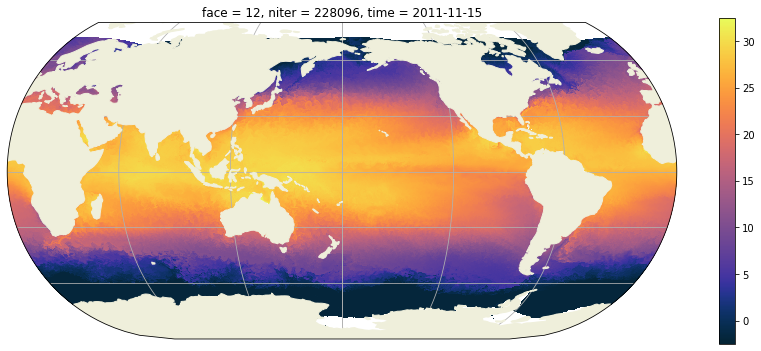

In [54]:
d = pl.plot_pretty(vplt,
                   vmin=-2.5,
                   vmax=32.5,
                   region='global_pacific', 
                   gridlines=False,
                   figsize=(15,6),
                   colorbar=True,
                  )

## Close cluster

In [ ]:
cluster.close()

In [28]:
for f in futures:
    f.cancel()

In [2]:
import dask
dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler

In [3]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time', 'trajectory'])

t_start = pd.Timestamp("2011-11-15")
t_end = pd.Timestamp("2011-11-25")

In [5]:
p.parquets['time']

'/home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/time'

In [5]:
df = dd.read_parquet(p.parquets['time'])
%time df = df.loc[(df.index>t_start)&(df.index<=t_end)].compute()

CPU times: user 1min 17s, sys: 46.8 s, total: 2min 3s
Wall time: 45.5 s


In [4]:
#filters=[('index', '<', np.datetime64('2011-12-01'))]
filters=[('index', '>=', t_start), ('index', '<=', t_end)]
%time df = dd.read_parquet(p.parquets['time'], 
                           engine='fastparquet', 
                           filters=filters
                          ).compute()

CPU times: user 1min 20s, sys: 58.9 s, total: 2min 19s
Wall time: 1min 2s


In [ ]:
df

In [7]:
%time llc = load_llc(8, t_start, t_end)

NameError: name 'load_llc' is not defined

In [1]:
df

NameError: name 'df' is not defined